In [1]:
from pyDeepInsight import ImageTransformer, LogScaler
import pandas as pd
import numpy as np
import pickle
import anndata
import random
from sklearn.manifold import TSNE
from sklearn import preprocessing
from timeit import default_timer as timer

In [2]:
reference = anndata.read_h5ad("reference_sct.h5ad")
#Scaling
min_max_scaler = preprocessing.MinMaxScaler()
scaled = pd.DataFrame(reference.X).transpose()
scaled = min_max_scaler.fit_transform(scaled)
scaled = pd.DataFrame(scaled).transpose()
scaled.index = reference.obs.index.values
scaled.columns = reference.var.index.values

In [3]:
#Get cell-type information from initial reference dataset
ref = anndata.read_h5ad("reference.h5ad")
obs = ref.obs.loc[scaled.index.tolist()]
scaled["celltype_l2"] = obs["celltype.l2"]
tags = scaled['celltype_l2'].unique().tolist()
train_ls = []
val_ls = []
test_ls = []
#Split dataset into training dataset, validation dataset and test dataset by 90:5:5
for tag in tags:
    df = pd.DataFrame(scaled[(scaled['celltype_l2'] == tag)].index.values)
    train_part = df.sample(frac=0.90)[0].tolist()
    df = df[~df[0].isin(train_part)]
    val_part = df.sample(frac=0.50)[0].tolist()
    df = df[~df[0].isin(val_part)]
    test_part = df.sample(frac=1.0)[0].tolist()
    train_ls = train_ls + train_part
    val_ls = val_ls + val_part
    test_ls = test_ls + test_part
    
train_rna = scaled.loc[train_ls]
val_rna = scaled.loc[val_ls]
test_rna = scaled.loc[test_ls]

train_rna

,HES4,ISG15,TNFRSF18,TNFRSF4,MXRA8,MIB2,MMP23B,PLCH2,SMIM1,GPR153,...,IGHV3-66,IGFL2,IGKV2-29,NXF3,IGHV4-31,IGHV3-73,IGLV9-49,IGKV2-24,IGHV2-26,celltype_l2
E2L5_GTAGAGGAGATCGGTG,0.078993,0.071290,0.080043,0.080799,0.084561,0.078188,0.081744,0.083373,0.083506,0.084231,...,0.085443,0.085416,0.085465,0.085408,0.085444,0.085372,0.085426,0.085465,0.085424,CD14 Mono
E2L7_TAAGCGTGTTGATGTC,0.145327,0.111963,0.097995,0.097497,0.103754,0.093636,0.099595,0.102178,0.101870,0.103253,...,0.104940,0.104842,0.104958,0.104905,0.104921,0.104843,0.104935,0.104960,0.104893,CD14 Mono
E2L6_AGAAATGTCGCTTAAG,0.185881,0.188200,0.188115,0.188685,0.197820,0.182976,0.191354,0.195228,0.195175,0.197056,...,0.199841,0.199723,0.199885,0.199765,0.199825,0.199668,0.199814,0.199888,0.199776,CD14 Mono
E2L7_TTAGGCACAGTAACCT,0.078676,0.083549,0.079450,0.079608,0.083231,0.077548,0.080686,0.082223,0.082184,0.082932,...,0.084064,0.084008,0.084083,0.084031,0.084056,0.083988,0.084053,0.084085,0.084033,CD14 Mono
E2L1_TAGACTGAGTATCTGC,0.374700,0.501399,0.156967,0.159805,0.164943,0.155761,0.160555,0.162908,0.163636,0.164441,...,0.166421,0.166441,0.166468,0.166349,0.166444,0.166304,0.166373,0.166467,0.166412,CD14 Mono
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L3_TTCTAGTCAACCACGC,0.128252,0.140925,0.351975,0.277704,0.132071,0.125553,0.129251,0.131148,0.130597,0.131731,...,0.133002,0.132857,0.133016,0.132970,0.132966,0.132900,0.133007,0.133020,0.132936,ILC
L1_TTTAGTCCAGCAGTTT,0.227456,0.216083,0.389940,0.391376,0.234279,0.225518,0.230046,0.232676,0.232479,0.233783,...,0.235817,0.235670,0.235856,0.235746,0.235789,0.235652,0.235799,0.235860,0.235740,ILC
L2_GACCGTGAGCGTGTTT,0.291547,0.323493,0.454937,0.295959,0.302119,0.292141,0.296988,0.299798,0.300561,0.301537,...,0.304010,0.303986,0.304074,0.303910,0.304026,0.303836,0.303953,0.304074,0.303976,ILC
L4_GGGTGTCGTCACAATC,0.136411,0.129617,0.136688,0.246756,0.139434,0.133672,0.136841,0.138646,0.138007,0.139121,...,0.140351,0.140184,0.140366,0.140317,0.140309,0.140240,0.140359,0.140370,0.140275,ILC


In [4]:
#Store cell-type information in this step for further training
pd.DataFrame(train_rna["celltype_l2"]).to_csv("./pretrained_10/trainy_pre.csv")
pd.DataFrame(val_rna["celltype_l2"]).to_csv("./pretrained_10/valy_pre.csv")
pd.DataFrame(test_rna["celltype_l2"]).to_csv("./pretrained_10/testy_pre.csv")

/home/shangru/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


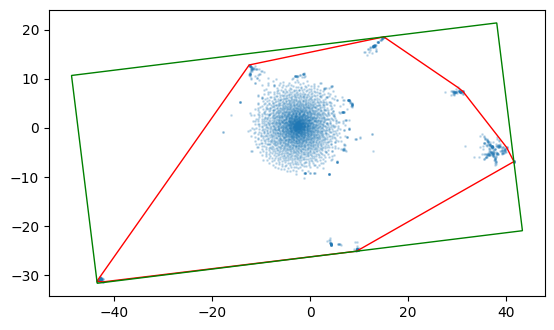

In [5]:
start = timer()
tsne = TSNE(n_components=2, perplexity=10, metric='euclidean', random_state=0, n_jobs=-1, learning_rate="auto", init='pca')
it = ImageTransformer(feature_extractor=tsne, pixels=224, random_state=0, n_jobs=-1)
it.fit(train_rna.iloc[:, :-1], plot=True)
#save image transformer
with open("/Usersdata/shangru/docker/pretrained_10/img_transformer_pre.obj","wb") as f:
    pickle.dump(it, f)

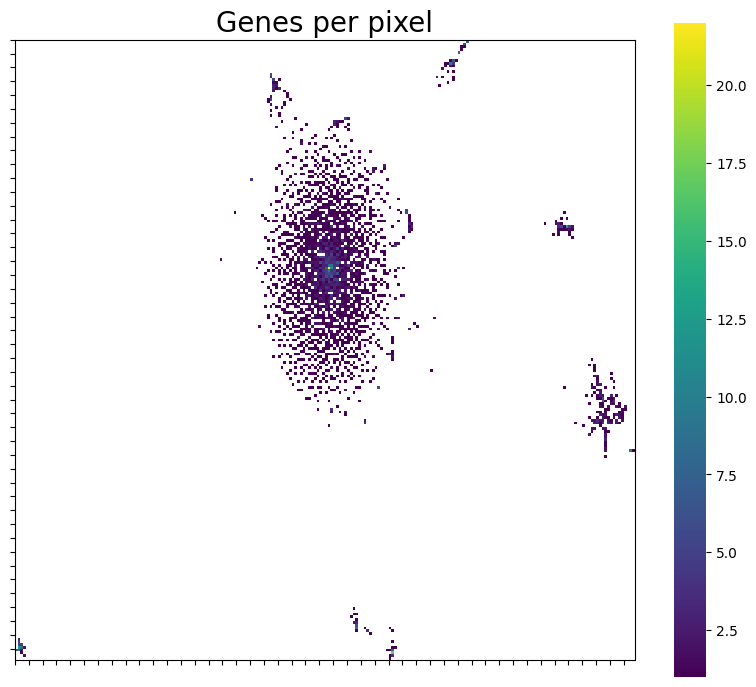

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 8.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel", fontsize = 20)

In [7]:
#Transform non-image processed datasets into images
rna_list = np.array_split(train_rna, 4)
#Split the dataset to avoid memory problems
rna1 = rna_list[0]
img_1 = (it.transform(rna1.iloc[:, :-1])*255).astype(np.uint8)
rna2 = rna_list[1]
img_2 = (it.transform(rna2.iloc[:, :-1])*255).astype(np.uint8)
rna3 = rna_list[2]
img_3 = (it.transform(rna3.iloc[:, :-1])*255).astype(np.uint8)
rna4 = rna_list[3]
img_4 = (it.transform(rna4.iloc[:, :-1])*255).astype(np.uint8)

train_img = np.concatenate((img_1, img_2, img_3, img_4), axis=0)
val_img = (it.transform(val_rna.iloc[:, :-1])*255).astype(np.uint8)
test_img = (it.transform(test_rna.iloc[:, :-1])*255).astype(np.uint8)

#Calculate the time consume in the image convertion process
end = timer()
print(end - start)

455.48748152400367


In [8]:
#Store processed images in npy format
path1 = '/Usersdata/shangru/docker/pretrained_10/train_pre.npy'
path2 = '/Usersdata/shangru/docker/pretrained_10/val_pre.npy'
path3 = '/Usersdata/shangru/docker/pretrained_10/test_pre.npy'

np.save(path1, train_img)
np.save(path2, val_img)
np.save(path3, test_img)